# 第十二週：BERT (Encoder-only-model)
Last modified: 蔡睿澤 (2024/05/06)<br><br>
本週課程為「BERT (Encoder-only-model)」，主要會介紹不同 BERT 相關下游任務的程式碼應用，學習目標著重在如何使用 BERT 相關資源（例如網路上別人訓練好的 BERT 模型）來達成 Token classification、Sequence classification 以及 Text Clustering 等等相關文字處理任務。

### 大綱：
1. 套件介紹
2. 資料前處理
3. Token classification<br>
  3.1 NER<br>
4. Sequence classification<br>
  4.1 Sentiment Classification<br>
  4.2 Relation Extraction (RE)<br>
5. Text Clustering<br>
  5.1 BERTopic 基本用法介紹<br>
  5.2 BERTopic 的 Embedding model<br>
  5.3 BERTopic 的 Clustering model<br>
  5.4 套用中文資料



### 1. 套件介紹

連接雲端資料夾

In [6]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Colab Notebooks/week12') # 請將這行修改為自己的 google drive 路徑
os.listdir() # 確認目錄內容

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['TaipeiSansTCBeta-Regular.ttf', 'dict', 'raw_data', 'week12_bert.ipynb']

前處理常用套件

In [ ]:
# !pip install jieba

In [7]:
import pandas as pd
import re
import numpy as np
from collections import defaultdict
import multiprocessing
import jieba
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 設定字體
fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

transformers 和 Sentence-transformers （使用 huggingface 模型）

In [ ]:
# !pip install sentence_transformers
# !pip install ckip_transformers

In [2]:
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

BERTopic

In [ ]:
# !pip install bertopic

In [16]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

### 2. 資料前處理

載入吃到飽示範資料集

In [19]:
# 讀入中文示範資料集
origin_data = pd.read_csv('./raw_data/zh_buffet_20_22.csv')

In [20]:
# 去除一些不需要的欄位
metaData = origin_data.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,餐廳名稱濃咖哩消費時間年月例年月
1,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,未提供則文章不予保留
2,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,多訪綜合心得也請標上起迄時間地址台北市開封街段巷號電話營業時間每人平均價位可否刷卡有無包廂推...
3,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,加飯加咖哩醬都免錢一直加飯加醬的話真的可以元吃到飽照片的是雞肉咖哩青菜雞肉用的是雞腿肉大概有...
4,1,https://www.ptt.cc/bbs/Food/M.1577942161.A.AC4...,[食記]台北中正濃咖哩平價美味份量大,2020-01-02 05:09:58,餐廳名稱：濃咖哩\n 消費時間：2019年1/12月\n (例：201...,其他的口味也吃過肉塊都不少豬肉用的是後腿肉牛肉用的是牛腱肉不會像大部分的平價咖哩飯醬吃起來都...
...,...,...,...,...,...,...
142627,1630,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30 12:28:11,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,總體來說
142628,1630,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30 12:28:11,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,這家頂鮮台南擔仔麵雖然對我們來說價格不算便宜
142629,1630,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30 12:28:11,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,但菜色跟口味確實都有一定的水準
142630,1630,https://www.ptt.cc/bbs/Food/M.1672374494.A.57F...,[食記]高雄苓雅｜頂鮮台南擔仔麵＿道地台菜料理,2022-12-30 12:28:11,餐廳名稱：頂鮮台南擔仔麵（高雄店）\n 消費時間：2022年12月\n 地址：802...,蠻適合在家族年節團聚或招待長輩時前來用餐


載入傲慢與偏見（已斷句）

In [9]:
# 讀入英文示範資料集
en_origin_data = pd.read_csv('./raw_data/en_sentence_chapter.csv')
en_origin_data.head()

,sentence,chapter
0,﻿TPRIDE & PREJUDICE.,0
1,"It is a truth universally acknowledged, that a...",1
2,However little known the feelings or views of ...,1
3,"""My dear Mr. Bennet,"" said his lady to him one...",1
4,Mr. Bennet replied that he had not.,1


### 3. Token classification

#### 3.1 NER
使用 Huggingface 上面已經針對 NER 任務 finetune 好的 BERT 模型來實作<br>
Huggingface 的模型列表：https://huggingface.co/models?sort=trending

如果找不到自己適用的模型的話，也可以透過 fine-tune 來建立自己的模型。<br>
本課程因為時間與資源因素，僅針對「如何使用網路上他人 fine-tune 好的模型」進行程式碼示範，不提供 fine-tune 程式碼範例。<br>
如有需要，可參考 Huggingface 相關教學文章：[Fine-tune a pretrained model](https://huggingface.co/docs/transformers/training)

中文 NER：<br>
使用套件：transformers<br>
使用的 NER 模型：https://huggingface.co/ckiplab/bert-base-chinese-ner

In [ ]:
model_name = 'ckiplab/bert-base-chinese-ner'
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

ner_pipe = pipeline('ner', model=model, tokenizer=tokenizer)
example = ["在環遊世界的3年裡，威尼斯我最愛的城市。"]

ner_results = ner_pipe(example)
ner_results

[[{'entity': 'B-DATE',
   'score': 0.9999993,
   'index': 7,
   'word': '3',
   'start': 6,
   'end': 7},
  {'entity': 'E-DATE',
   'score': 0.9999994,
   'index': 8,
   'word': '年',
   'start': 7,
   'end': 8},
  {'entity': 'B-GPE',
   'score': 0.99999833,
   'index': 11,
   'word': '威',
   'start': 10,
   'end': 11},
  {'entity': 'I-GPE',
   'score': 0.9999988,
   'index': 12,
   'word': '尼',
   'start': 11,
   'end': 12},
  {'entity': 'E-GPE',
   'score': 0.9999989,
   'index': 13,
   'word': '斯',
   'start': 12,
   'end': 13}]]

使用 CKIP 開發的 NLP 套件：ckip_transformers<br>
使用的 WS 模型：https://huggingface.co/ckiplab/bert-base-chinese-ws<br>
使用的 POS 模型：https://huggingface.co/ckiplab/bert-base-chinese-pos<br>
使用的 NER 模型：https://huggingface.co/ckiplab/bert-base-chinese-ner

In [ ]:
# 初始化 ckip 工具
ws_driver  = CkipWordSegmenter(model_name="ckiplab/bert-base-chinese-ws", device=0)
pos_driver = CkipPosTagger(model_name="ckiplab/bert-base-chinese-pos", device=0)
ner_driver = CkipNerChunker(model_name="ckiplab/bert-base-chinese-ner", device=0)

# 想要進行處理的句子
text = [
   "傅達仁今將執行安樂死，卻突然爆出自己20年前遭緯來體育台封殺，他不懂自己哪裡得罪到電視台。",
   "美國參議院針對今天總統布什所提名的勞工部長趙小蘭展開認可聽證會，預料她將會很順利通過參議院支持，成為該國有史以來第一位的華裔女性內閣成員。"
]

# 執行
ws = ws_driver(text)
pos = pos_driver(ws)
ner = ner_driver(text)

Inference: 100%|██████████| 1/1 [00:00<00:00, 47.01it/s]


In [ ]:
# 將斷詞以及 pos 結果合在一起顯示
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos)
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      res.append(f"{word_ws}({word_pos})")
   return "\u3000".join(res)

# 顯示處理結果
for sentence, sentence_ws, sentence_pos, sentence_ner in zip(text, ws, pos, ner):
   print(sentence)
   print(pack_ws_pos_sentece(sentence_ws, sentence_pos))
   for entity in sentence_ner:
      print(entity)
   print()

傅達仁今將執行安樂死，卻突然爆出自己20年前遭緯來體育台封殺，他不懂自己哪裡得罪到電視台。
傅達仁(Nb)　今(Nd)　將(D)　執行(VC)　安樂死(Na)　，(COMMACATEGORY)　卻(D)　突然(D)　爆出(VJ)　自己(Nh)　20(Neu)　年(Nf)　前(Ng)　遭(P)　緯來(Nb)　體育台(Na)　封殺(VC)　，(COMMACATEGORY)　他(Nh)　不(D)　懂(VK)　自己(Nh)　哪裡(Ncd)　得罪到(VC)　電視台(Nc)　。(PERIODCATEGORY)
NerToken(word='傅達仁', ner='PERSON', idx=(0, 3))
NerToken(word='20年', ner='DATE', idx=(18, 21))
NerToken(word='緯來體育台', ner='ORG', idx=(23, 28))

美國參議院針對今天總統布什所提名的勞工部長趙小蘭展開認可聽證會，預料她將會很順利通過參議院支持，成為該國有史以來第一位的華裔女性內閣成員。
美國(Nc)　參議院(Nc)　針對(P)　今天(Nd)　總統(Na)　布什(Nb)　所(D)　提名(VC)　的(DE)　勞工部長(Na)　趙小蘭(Nb)　展開(VC)　認可(VC)　聽證會(Na)　，(COMMACATEGORY)　預料(VE)　她(Nh)　將(D)　會(D)　很(Dfa)　順利(VH)　通過(VC)　參議院(Nc)　支持(Nv)　，(COMMACATEGORY)　成為(VG)　該(Nes)　國(Nc)　有史以來(D)　第一(Neu)　位(Nf)　的(DE)　華裔(Na)　女性(Na)　內閣(Na)　成員(Na)　。(PERIODCATEGORY)
NerToken(word='美國參議院', ner='ORG', idx=(0, 5))
NerToken(word='今天', ner='LOC', idx=(7, 9))
NerToken(word='布什', ner='PERSON', idx=(11, 13))
NerToken(word='勞工部長', ner='ORG', idx=(17, 21))
NerToken(word='趙小蘭', ner='PERSON', idx=(21, 24))
NerToken(word='認

套用到我們先前處理好的資料集

In [ ]:
text = metaData['sentence'].tolist()

# 執行
ws = ws_driver(text)
pos = pos_driver(ws)
ner = ner_driver(text)

# 將斷詞以及 pos 結果合在一起顯示
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos)
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      res.append(f"{word_ws}({word_pos})")
   return "\u3000".join(res)

sentences, packed_sentences, entities = [], [], []

# 儲存結果
for sentence, sentence_ws, sentence_pos, sentence_ner in zip(text, ws, pos, ner):
   sentences.append(sentence)
   packed_sentences.append(pack_ws_pos_sentece(sentence_ws, sentence_pos))
   entities.append([str(entity) for entity in sentence_ner])

# 將結果存在一個 dataframe 中
ner_results = pd.DataFrame({
   'sentence': sentences,
   'packed_sentence': packed_sentences,
   'entities': entities
})

ner_results


Inference: 100%|██████████| 66/66 [06:10<00:00,  5.61s/it]


,sentence,packed_sentence,entities
0,餐廳名稱濃咖哩消費時間年月例年月,餐廳(Nc) 名稱(Na) 濃(VH) 咖哩(Na) 消費(Na) 時間(Na) 年(Na)...,[]
1,未提供則文章不予保留,未(D) 提供(VD) 則(D) 文章(Na) 不予(VL) 保留(VC),[]
2,多訪綜合心得也請標上起迄時間地址台北市開封街段巷號電話營業時間每人平均價位可否刷卡有無包廂推...,多(D) 訪(VC) 綜合(A) 心得(Na) 也(D) 請(VF) 標上(VC) 起迄(A...,"[NerToken(word='台北市', ner='GPE', idx=(16, 19))..."
3,加飯加咖哩醬都免錢一直加飯加醬的話真的可以元吃到飽照片的是雞肉咖哩青菜雞肉用的是雞腿肉大概有...,加飯(VC) 加(VC) 咖哩醬(Na) 都(D) 免(VJ) 錢(Na) 一直(D) 加飯...,"[NerToken(word='日式', ner='NORP', idx=(51, 53))..."
4,其他的口味也吃過肉塊都不少豬肉用的是後腿肉牛肉用的是牛腱肉不會像大部分的平價咖哩飯醬吃起來都...,其他(Neqa) 的(DE) 口味(Na) 也(D) 吃(VC) 過(Di) 肉塊(Na) ...,"[NerToken(word='一次', ner='CARDINAL', idx=(91, ..."
...,...,...,...
17080,煮熟之後口感清脆跟豬肝會有點粉粉的口感不太一樣最後我們四大一小吃了四盤肉一盤牛肝,煮熟(VB) 之後(Ng) 口感(Na) 清脆(VH) 跟(Caa) 豬肝(Na) 會(D)...,"[NerToken(word='四', ner='CARDINAL', idx=(27, 2..."
17081,大滿足,大滿足(VH),[]
17082,新鮮的溫體牛就是好吃啊,新鮮(VH) 的(DE) 溫體(A) 牛(Na) 就(D) 是(SHI) 好吃(VH) 啊(T),[]
17083,那些關於宇宇的生活日常,那些(Neqa) 關於(P) 宇宇(Nb) 的(DE) 生活(Na) 日常(Nd),[]


可以依據前幾週的程式碼，對 NER 後的句子進行近一步的探索

注意：不同的 NER 模型因為 fine-tune 的方法與資料不相同，所以不同的 NER 模型間，Entity Types 不一定相同。<br>
以使用醫學領域資料 fine-tune 的 NER 模型為例：https://huggingface.co/Clinical-AI-Apollo/Medical-NER

（補充）英文 NER：<br>
使用套件：transformers<br>
使用的 NER 模型：https://huggingface.co/dslim/bert-base-NER

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = [
    "My name is Wolfgang and I live in Berlin",
    "Obama was a USA president."
]

ner_results = nlp(example)
ner_results

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[[{'entity': 'B-PER',
   'score': 0.9990139,
   'index': 4,
   'word': 'Wolfgang',
   'start': 11,
   'end': 19},
  {'entity': 'B-LOC',
   'score': 0.999645,
   'index': 9,
   'word': 'Berlin',
   'start': 34,
   'end': 40}],
 [{'entity': 'B-PER',
   'score': 0.9987392,
   'index': 1,
   'word': 'Obama',
   'start': 0,
   'end': 5},
  {'entity': 'B-LOC',
   'score': 0.99977475,
   'index': 4,
   'word': 'USA',
   'start': 12,
   'end': 15}]]

### 4. Sequence classification

#### 4.1 Sentiment Classification
使用 Huggingface 上面已經針對 Sentiment classification 任務 finetune 的 BERT 模型來實作<br>
使用的模型：https://huggingface.co/techthiyanes/chinese_sentiment<br><br>
情緒：<br>
1: Semi-negation<br>
2: Negation<br>
3: Neutral<br>
4: Semi-positive<br>
5: Positive

In [ ]:
# 載入已經被 fine-tune 過的 BERT 模型
model_name = "techthiyanes/chinese_sentiment"  # 你可以將這裡換成你想要使用的模型
model = pipeline('sentiment-analysis', model=model_name)

# 使用模型來進行情緒分析
text = ["我喜歡這部電影！", "他的行為讓我很困擾"]
result = model(text)

# 輸出結果
result


[{'label': 'star 4', 'score': 0.4818800389766693},
 {'label': 'star 1', 'score': 0.24347198009490967}]

In [ ]:
# 建立一個新的 dataframe 來儲存結果
results_df = pd.DataFrame(columns=['sentence', 'label', 'score'])
results_df['sentence'] = metaData['sentence']

# 定義一個函數來進行情緒分析
def analyze_sentiment(sentence):
    result = model([sentence])
    return pd.Series([result[0]['label'], result[0]['score']])

# 使用 apply 函數來進行情緒分析
results_df[['label', 'score']] = metaData['sentence'].apply(analyze_sentiment)

# 輸出結果
results_df

,sentence,label,score
0,餐廳名稱濃咖哩消費時間年月例年月,star 4,0.351639
1,未提供則文章不予保留,star 1,0.619397
2,多訪綜合心得也請標上起迄時間地址台北市開封街段巷號電話營業時間每人平均價位可否刷卡有無包廂推...,star 5,0.609836
3,加飯加咖哩醬都免錢一直加飯加醬的話真的可以元吃到飽照片的是雞肉咖哩青菜雞肉用的是雞腿肉大概有...,star 4,0.506510
4,其他的口味也吃過肉塊都不少豬肉用的是後腿肉牛肉用的是牛腱肉不會像大部分的平價咖哩飯醬吃起來都...,star 5,0.523491
...,...,...,...
2237,現在會員跟萬豪是合併的有會員的朋友記得不要忘記出示會員卡像我有金卡,star 1,0.292114
2238,消費會有折算大放否則這種頂級飯店品牌要打折真的很難哈哈,star 4,0.637222
2239,香港雖然大樓多,star 4,0.384418
2240,不過其實高空酒吧並沒有到非常多大賣點除了全球最高還有傳統以來細膩的服務品質香港高級餐飲還是有...,star 4,0.582950


可以依據前幾週的程式碼，對情緒分析後的句子進行近一步的探索

#### 4.2 Relation Extraction (RE)
使用 Huggingface 上面已經針對 RE 任務 finetune 的 BERT 模型來實作<br>
使用的模型：https://huggingface.co/teppei727/bert-large-relation14

In [3]:
tokenizer = AutoTokenizer.from_pretrained("teppei727/bert-large-relation14")
model = AutoModelForSequenceClassification.from_pretrained("teppei727/bert-large-relation14", ignore_mismatched_sizes=True)

re_model = pipeline("text-classification", model=model, tokenizer=tokenizer)

# 使用模型來進行 RE
text = [
    "My name is Wolfgang and I live in Berlin",
    "Obama was a USA president."
]
result = re_model(text)

# 輸出結果
result

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[{'label': '[no connective]', 'score': 0.5112497210502625},
 {'label': 'Expansion.Conjunction', 'score': 0.6735779047012329}]

In [11]:
# 建立一個新的 dataframe 來儲存結果
re_results_df = pd.DataFrame(columns=['sentence', 'label', 'score'])
re_results_df['sentence'] = en_origin_data['sentence']

# 定義一個函數來進行 RE 任務
def get_re_result(sentence):
    result = re_model([sentence])
    return pd.Series([result[0]['label'], result[0]['score']])

# 使用 apply 函數來進行 RE 任務
re_results_df[['label', 'score']] = en_origin_data['sentence'].apply(get_re_result)

# 輸出結果
re_results_df

,sentence,label,score
0,﻿TPRIDE & PREJUDICE.,[no connective],0.996502
1,"It is a truth universally acknowledged, that a...",Expansion.Conjunction,0.946982
2,However little known the feelings or views of ...,Expansion.Conjunction,0.962074
3,"""My dear Mr. Bennet,"" said his lady to him one...",Expansion.Conjunction,0.658451
4,Mr. Bennet replied that he had not.,Expansion.Conjunction,0.772690
...,...,...,...
95,"""While Mary is adjusting her ideas,"" he contin...",[no connective],0.335870
96,"Bingley.""",Expansion.Conjunction,0.826127
97,"""I am sick of Mr. Bingley,"" cried his wife.",Expansion.Conjunction,0.824666
98,"""I am sorry to hear _that_; but why did not yo...",[no connective],0.690470


注意：RE 跟 NER 一樣，不同的模型會有不同的關係型態，尤其是使用特定領域資料 fine-tune 的模型，通常會有該特定領域專有的關係型態

### 5. Text Clustering

以下使用 BERTopic 來實作 BERT-based 的 Text Clustering，並介紹 clustering-based 的主題模型<br>
BERTopic: https://maartengr.github.io/BERTopic/index.html<br>
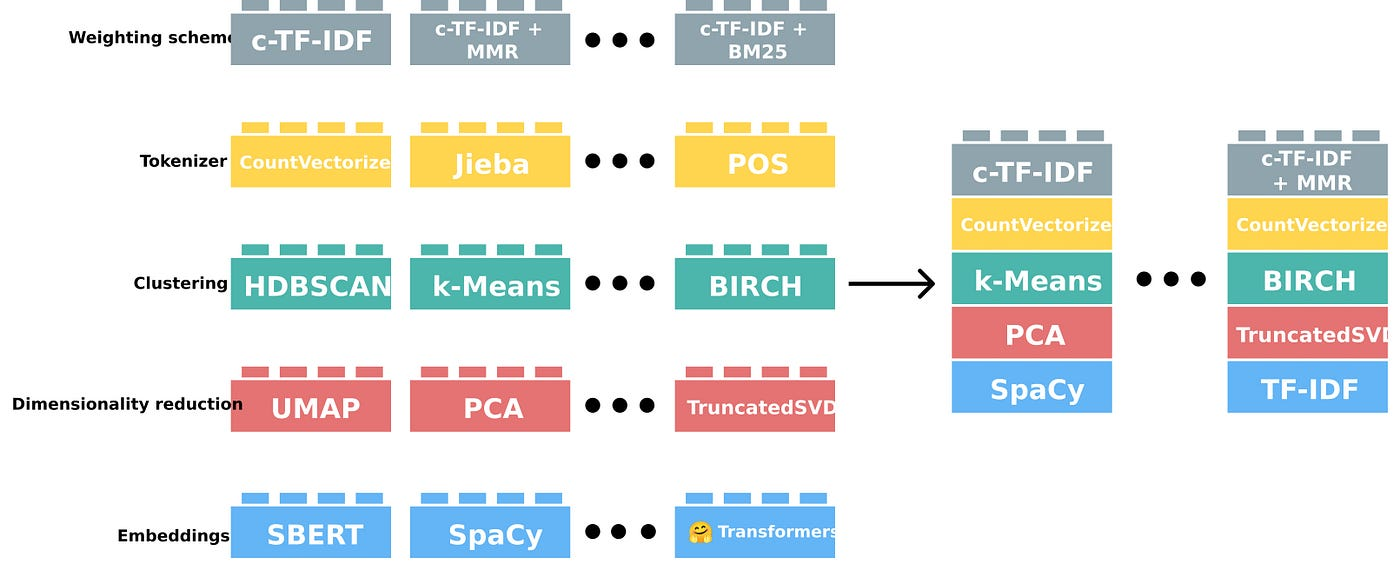

#### 5.1 基本用法介紹

In [39]:
docs = en_origin_data['sentence'].tolist()

# 定義不同 layer 所要使用的模型與方法
embedding_model = "all-MiniLM-L6-v2"
hdbscan_model = HDBSCAN()
vectorizer_model = CountVectorizer()

topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(docs[:500])

In [40]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,138,-1_the_of_and_in,"[the, of, and, in, was, to, he, that, she, her]","[After a song or two, and before she could rep..."
1,0,46,0_you_it_not_did,"[you, it, not, did, do, no, compliment, _that_...","[""Do you not think it would be a proper compli..."
2,1,39,1_bennet_mrs_mr_netherfield,"[bennet, mrs, mr, netherfield, that, of, the, ...","[Mr. Bennet replied that he had not., ""Why, my..."
3,2,33,2_darcy_mr_to_his,"[darcy, mr, to, his, of, the, and, at, was, with]",[Between him and Darcy there was a very steady...
4,3,27,3_bingley_her_mr_and,"[bingley, her, mr, and, miss, you, may, not, h...",[I dare say Mr. Bingley will be very glad to s...
5,4,22,4_nerves_vanity_to_you,"[nerves, vanity, to, you, are, agreeable, have...",[There is so much of gratitude or vanity in al...
6,5,19,5_jane_was_elizabeth_her,"[jane, was, elizabeth, her, to, by, she, and, ...","[Elizabeth, easy and unaffected, had been list..."
7,6,18,6_eliza_dance_danced_he,"[eliza, dance, danced, he, with, you, the, mis...",[He paused in hopes of an answer; but his comp...
8,7,17,7_he_his_and_there,"[he, his, and, there, was, manners, him, women...",[They were in fact very fine ladies; not defic...
9,8,17,8_lucas_miss_to_the,"[lucas, miss, to, the, william, his, lady, and...",[Sir William Lucas had been formerly in trade ...


In [41]:
topic_model.get_topic(6)

[('eliza', 0.07977852512899754),
 ('dance', 0.06522650498075691),
 ('danced', 0.0646646650665418),
 ('he', 0.053094325823787196),
 ('with', 0.04987044998882721),
 ('you', 0.0399128526699901),
 ('the', 0.036320507372667836),
 ('miss', 0.036182718719365375),
 ('two', 0.03606153206739654),
 ('at', 0.035515099989344594)]

In [42]:
topic_model.get_document_info(docs[:500])

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,﻿TPRIDE & PREJUDICE.,-1,-1_the_of_and_in,"[the, of, and, in, was, to, he, that, she, her]","[After a song or two, and before she could rep...",the - of - and - in - was - to - he - that - s...,0.000000,False
1,"It is a truth universally acknowledged, that a...",14,14_single_fortune_one_man,"[single, fortune, one, man, or, of, is, husban...",[A single man of large fortune; four or five t...,single - fortune - one - man - or - of - is - ...,1.000000,True
2,However little known the feelings or views of ...,13,13_our_think_daughters_silly,"[our, think, daughters, silly, children, of, t...","[""I am astonished, my dear,"" said Mrs. Bennet,...",our - think - daughters - silly - children - o...,0.479135,True
3,"""My dear Mr. Bennet,"" said his lady to him one...",1,1_bennet_mrs_mr_netherfield,"[bennet, mrs, mr, netherfield, that, of, the, ...","[Mr. Bennet replied that he had not., ""Why, my...",bennet - mrs - mr - netherfield - that - of - ...,0.608934,False
4,Mr. Bennet replied that he had not.,1,1_bennet_mrs_mr_netherfield,"[bennet, mrs, mr, netherfield, that, of, the, ...","[Mr. Bennet replied that he had not., ""Why, my...",bennet - mrs - mr - netherfield - that - of - ...,0.766615,True
...,...,...,...,...,...,...,...,...
495,Elizabeth was glad to be taken to her immediat...,5,5_jane_was_elizabeth_her,"[jane, was, elizabeth, her, to, by, she, and, ...","[Elizabeth, easy and unaffected, had been list...",jane - was - elizabeth - her - to - by - she -...,0.841443,False
496,"She was not equal, however, to much conversati...",3,3_bingley_her_mr_and,"[bingley, her, mr, and, miss, you, may, not, h...",[I dare say Mr. Bingley will be very glad to s...,bingley - her - mr - and - miss - you - may - ...,0.567498,False
497,Elizabeth silently attended her.,5,5_jane_was_elizabeth_her,"[jane, was, elizabeth, her, to, by, she, and, ...","[Elizabeth, easy and unaffected, had been list...",jane - was - elizabeth - her - to - by - she -...,0.937293,False
498,"When breakfast was over, they were joined by t...",-1,-1_the_of_and_in,"[the, of, and, in, was, to, he, that, she, her]","[After a song or two, and before she could rep...",the - of - and - in - was - to - he - that - s...,0.000000,False


In [ ]:
topic_model.visualize_topics()

#### 5.2 Embedding model<br>
BERTopic 支援多種 embedding 模型與方法，包含基本的 Huggingface 模型，也提供了 LLM-based 的 embedding 可做選擇。<br>
更多請參考文件：https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#scikit-learn-embeddings

In [ ]:
# 使用 sentence_transformers 相關語言模型作為 embedding_model
sentence_model = SentenceTransformer("google-bert/bert-base-uncased")

# 定義不同 layer 所要使用的模型與方法
hdbscan_model = HDBSCAN()
vectorizer_model = CountVectorizer()

# 將 BERTopic 的 embedding_model 替換為其他模型（sentence_model）
embed_topic_model = BERTopic(embedding_model=sentence_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model)
topics, probs = embed_topic_model.fit_transform(docs[:500])

In [ ]:
import openai
from bertopic.backend import OpenAIBackend

# 也可以使用 OpenAI API 來獲取性能更強大的語言模型作為 embedding_model
client = openai.OpenAI(api_key="請替換為你的 openai key")
openai_embedding_model = OpenAIBackend(client, "text-embedding-ada-002")

# 定義不同 layer 所要使用的模型與方法
hdbscan_model = HDBSCAN()
vectorizer_model = CountVectorizer()

# 將 BERTopic 的 embedding_model 替換為其他模型（openai_embedding_model）
openai_topic_model = BERTopic(embedding_model=openai_embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model)
topics, probs = openai_topic_model.fit_transform(docs[:500])

#### 5.3 Clustering model<br>
參考文件：https://maartengr.github.io/BERTopic/getting_started/clustering/clustering.html

調整 topic modeling 流程中的 clustering 算法

In [47]:
# 使用 KMeans 作為分群算法，需要指定分群個數
cluster_model = KMeans(n_clusters=10)

# 定義不同 layer 所要使用的模型與方法
embedding_model = "all-MiniLM-L6-v2"
vectorizer_model = CountVectorizer()

# 將 BERTopic 的 hdbscan_model 替換為其他模型（cluster_model）
kmeans_topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=cluster_model, vectorizer_model=vectorizer_model)
topics, probs = kmeans_topic_model.fit_transform(docs[:500])

kmeans_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,73,0_of_is_to_be,"[of, is, to, be, you, it, in, are, the, if]",[They always continue to grow sufficiently unl...
1,1,69,1_you_it_not_but,"[you, it, not, but, do, that, is, them, to, did]","[""It will be no use to us, if twenty such shou..."
2,2,56,2_bingley_mr_the_of,"[bingley, mr, the, of, and, was, to, his, her,...","[Bingley intended it likewise, and sometimes m..."
3,3,55,3_the_was_her_and,"[the, was, her, and, of, jane, to, she, their,...","[She was shewn into the breakfast-parlour, whe..."
4,4,53,4_bennet_mrs_mr_of,"[bennet, mrs, mr, of, to, that, the, and, said...","[Mr. Bennet replied that he had not., ""Why, my..."
5,5,51,5_darcy_to_lucas_mr,"[darcy, to, lucas, mr, the, his, and, of, with...","[And taking her hand, he would have given it t..."
6,6,50,6_he_and_the_had,"[he, and, the, had, was, in, to, his, of, her]",[Of this she was perfectly unaware;--to her he...
7,7,45,7_you_to_and_not,"[you, to, and, not, long, it, for, the, him, w...","[But if _we_ do not venture, somebody else wil..."
8,8,29,8_dance_lizzy_he_eliza,"[dance, lizzy, he, eliza, you, not, with, the,...","[""You excel so much in the dance, Miss Eliza, ..."
9,9,19,9_oh_officers_the_length,"[oh, officers, the, length, names, ah, severe,...","[""Oh!, ""Oh!, ""Oh!]"


查看 text clustering 結果

In [48]:
topics[:10]

[5, 0, 0, 4, 4, 7, 4, 1, 2, 1]

#### 5.4 套用於中文<br>
為了套用到中文文章，各元件必須修改為支援中文的方法，主要針對 embedding model 以及 tokenizer

In [25]:
# 中文文章
docs_zh = metaData['sentence'].tolist()[:500]

# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增 stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]

# 設定中文 embedding model
bert_sentence_model = SentenceTransformer("google-bert/bert-base-chinese")

# 將中文文章轉換為 embedding
embeddings = bert_sentence_model.encode(docs_zh, show_progress_bar=True)

# 定義不同 clustering layer 所要使用的模型與方法（就用 default 的 HDBSCAN）
hdbscan_model = HDBSCAN()

# 定義一個適合中文的分詞函數
def tokenize_zh(text):
    words = jieba.lcut(text)
    return words

# 建立一個使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words=stopwords, analyzer='word', token_pattern=u"(?u)\\b\\w+\\b")

# 使用 BERTopic 進行主題模型建立
zh_topic_model = BERTopic(embedding_model=bert_sentence_model, vectorizer_model=jieba_vectorizer, verbose=True, top_n_words=30)
topics, probs = zh_topic_model.fit_transform(docs_zh, embeddings)

zh_topic_model.get_topic_info()

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2024-05-06 17:06:49,730 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-06 17:06:53,511 - BERTopic - Dimensionality - Completed ✓
2024-05-06 17:06:53,513 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-06 17:06:53,539 - BERTopic - Cluster - Completed ✓
2024-05-06 17:06:53,546 - BERTopic - Representation - Extracting topics from clusters using representation models.
Building prefix dict from /content/drive/MyDrive/Colab Notebooks/week12/dict/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/Colab Notebooks/week12/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.u39b4392aeebd568cad6e8c04a61bc98a.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.u39b4392aeebd568cad6e8c04a61bc98a.cache
Loading model cost 1.602 seconds.
DEBUG:jieba:Loading model cost 1.602 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.
2024-05-06 17:06:55,310 - BERTopic

,Topic,Count,Name,Representation,Representative_Docs
0,-1,207,-1_ _吃_壽司_宏,"[ , 吃, 壽司, 宏, 麵, 好吃, 味道, 份量, 說, 小慧涼, 羽諾, 甜點, 飲...","[是真正的可以吃到飽, 這裡都吃得到, 就是沒什麼味道但是在宏壽司]"
1,0,87,0_ _求婚_戒指_朋友,"[ , 求婚, 戒指, 朋友, 飛機, 升, 吃, 早餐, 笑, 回去, 第一次, 特別, ...","[眼尖的服務人員看到了求婚戒指的紙袋, 我笑著說是幫朋友帶戒指回去, 很寶貝地把朋友的求婚戒..."
2,1,49,1_ _吃_真的_價格,"[ , 吃, 真的, 價格, 美食, 平價, 炒飯, 品質, 牛肉, 朋友, 低, 抓, 喝...","[在台北根本不可能有這種價格但目前在台北吃到品質與預算與宏壽司最相近的, 這盤牛肉炒飯上桌時..."
3,2,45,2_丼_海鮮_咖哩_壽司,"[丼, 海鮮, 咖哩, 壽司, , 飯, 海膽, 招牌, 快樂, 鮨, 魚料, 肉, 吃,...","[超喜歡招牌海鮮丼這是我之前來宏壽司點的招牌海鮮景干貝海膽與滿滿的各式生魚料理, 於是我們決..."
4,3,33,3_起司_ _番茄_油脂,"[起司, , 番茄, 油脂, 蝦夷蔥, 鮮甜, 提出, 聞到, 香甜, 口中, 火腿, 鮪...","[能完美地將肥潤油脂與肉的香甜在口中爆發, 起司番茄蝦夷蔥跟生火腿蜜瓜, 起司番茄蝦夷蔥口味雖重]"
5,4,30,4_時間_電話_地址_營業時間,"[時間, 電話, 地址, 營業時間, 消費, 樹林, 顆星, 平均, 名稱, 網誌, 餐廳,...",[多訪綜合心得也請標上起迄時間地址台北市開封街段巷號電話營業時間每人平均價位可否刷卡有無包廂...
6,5,23,5_元_鍋元_雞肉_,"[元, 鍋元, 雞肉, , 白菜, 沙朗, 酸, 瓜類, 湯也, 清脆, 藍莓, 軟棉, ...","[酸白菜鍋雞肉, 雞肉元, 酸白菜鍋元]"
7,6,14,6_肉_油脂_肥肉_厚度,"[肉, 油脂, 肥肉, 厚度, 冷凍, 牛舌, 只不過, , 香, 烤熟, 更好, 某種程...","[其中不會有任何劣質的冷凍肉也不會冰到出水, 牛腹肉因為有油脂吃起來很柔嫩又有點彈性, 牛舌..."
8,7,12,7_包廂_用餐_喔_中文,"[包廂, 用餐, 喔, 中文, 位置, 無障礙, 點餐, 環境, 坐, 服務, 菜單, 牆,...","[其中最棒的就是有這樣的小包廂小包廂內可以坐六個人其中可以有兩個烤爐, 晚上七點到這用餐位置..."


In [ ]:
zh_topic_model.visualize_topics()

查看特定文章的主題分佈

In [27]:
topic_distr, _ = zh_topic_model.approximate_distribution(docs_zh)

100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


In [ ]:
zh_topic_model.visualize_distribution(topic_distr[18])

In [29]:
zh_topic_model.get_topic(2)

[('丼', 0.11781039352320004),
 ('海鮮', 0.1151508355107092),
 ('咖哩', 0.07286666786461687),
 ('壽司', 0.06301898725884345),
 (' ', 0.05010200414513566),
 ('飯', 0.04470660867872501),
 ('海膽', 0.044204640668165866),
 ('招牌', 0.04045785048580575),
 ('快樂', 0.03842096168002944),
 ('鮨', 0.036761962162519646),
 ('魚料', 0.036761962162519646),
 ('肉', 0.03567025428003522),
 ('吃', 0.03543794975624244),
 ('宏', 0.0351411561302239),
 ('雞肉', 0.03415629124179571),
 ('牛肉', 0.03309459764623885),
 ('國產', 0.03231916909831613),
 ('麵', 0.029686913859508526),
 ('老闆', 0.02881572126002208),
 ('味', 0.02881572126002208),
 ('生魚', 0.027571471621889734),
 ('口味', 0.027571471621889734),
 ('湯', 0.027571471621889734),
 ('豬肉', 0.027571471621889734),
 ('新鮮', 0.027571471621889734),
 ('料理', 0.02411087814271085),
 ('涼', 0.02411087814271085),
 ('精緻', 0.023408545395131052),
 ('邊握', 0.023408545395131052),
 ('邊肉', 0.023408545395131052)]

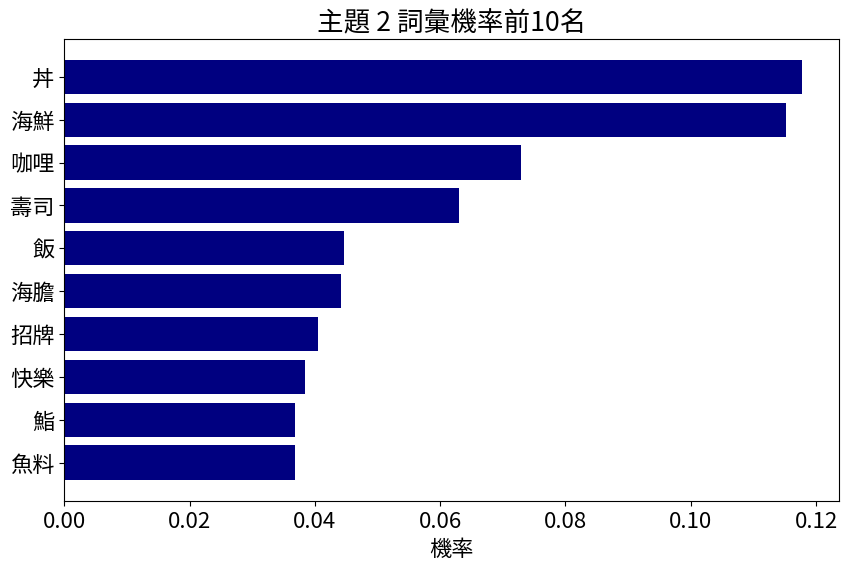

In [31]:
# 視覺化顯示主題-詞彙分佈
topic_n = 2
data = zh_topic_model.get_topic(topic_n)

# 轉換為DataFrame
df = pd.DataFrame(data, columns=['word', 'prob'])
df = df[df['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = df.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()